# Bayesian Experimental Design for model selection V2

## Average of fluorescence reporters, 2 step experiment

This script follows the same scheme as the ones used for the OED but introduces the compilation of some scripts in C using Cython and Parallelisation in order to increase speed

   ............................................................................................................................................................................................................................................

### Import Required libraries

In [1]:
# Common python libraries
import numpy as np
# from scipy.integrate import odeint
# from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
# import scipy
import pandas as pd
# import seaborn as sns
import pickle
# import math

# Gaussian Process Fitting Scripts
import gaussianprocess as gp
# from fitderiv import fitderiv
# import genutils as gu
# import datetime

# Bayesian Optimisation Scripts
from bayes_opt import BayesianOptimization
# from bayes_opt.observer import JSONLogger
# from bayes_opt.event import Events
# from bayes_opt.util import load_logs

# Avoid unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Multiprocessing
from multiprocessing import Pool
import multiprocessing as mp

# Functions with Models compyled with Cython
# import Model1_Cython as M1
# import Model2_Cython as M2
# import Model3_Cython as M3

# Function to simulate the 3 models for all parameter draws (needed in separate file for multiprocessesing in windows)
import SolveALLCy as SAC

# Bhattacharyya Distance Function 
import BhattacharyyaDistanceV1 as BD


### Example:

In [2]:
# Initial experimental value for all the states
ivss = [1,1e-7,28.510,1363.193]
# ON inducers 
pre = [1,1e-7]
# Inputs of the experiment
inputs = np.empty(18) # What needs to be optimised    --> example: [1e-7,100,1,1e-7]*4+[1e-7,100]
evnT = [int(i) for i in list(np.linspace(0,(24*60),10))]
# Time Vector
t = np.linspace(0,(24*60),(24*60)+1)
# Theta samples from posterior distribution of Model 3
pM3 = np.asarray(pd.read_csv("ParametersCSV/draws_ALL_Model3.stan.csv"))

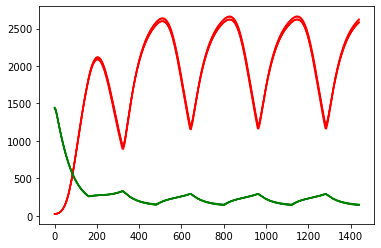

In [3]:
# Subsample of theta
p = pM3[0:5,:]
# Solve System for Model 3
test = SAC.solveALLCy2(t,p,evnT,[1e-7,100,1,1e-7]*4+[1e-7,100],ivss,pre, 'M3')
# Plot
plt.figure()
plt.plot(t[::5], test[:,0:5], 'r')
plt.plot(t[::5], test[:,5:10], 'g')
plt.show()

### Utility Function

In [ ]:
def utility2 (IPTG1, IPTG2,
             aTc1, aTc2):
    
    # Definition of inputs for the ODEs
        
    inputs = [round(IPTG1,2)+1e-7, int(aTc1)+1e-7, round(IPTG2,2)+1e-7, int(aTc2)+1e-7]
    
    # Initial values for steady state and inputs
    ivss = [1,1e-7,1363.193,28.510]
    pre = [1,1e-7]
    # Event switches and inputs
    sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
    t =  np.linspace(0,(24*60),(24*60)+1)
    
    # load parameter draws for the two models
    pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
    pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))
    
    # Simulation of the system for the two models and extract of results
#     solM1 = SAC.solveALLCy2(t, pM1, sp, inputs, ivss, pre, 'M1')
#     solM2 = SAC.solveALLCy2(t, pM2, sp, inputs, ivss, pre, 'M2')
#        PARALELISATION
    if __name__ ==  '__main__': 
        num_processors = mp.cpu_count()
        p=Pool(processes = num_processors)
        for i in range(0,2):
            if i==0:
                r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inputs, ivss, pre, 'M1'))
            elif i==1:
                r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inputs, ivss, pre, 'M2'))
        
        p.close()
        p.join() 
    
    solM1 = r1.get()
    solM2 = r2.get()    
    
    RFP_M1 = solM1[:,0:len(pM1[:,1])]
    GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]
    
    RFP_M2 = solM2[:,0:len(pM2[:,1])]
    GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]
    
    # Gaussian Process Regression and Reduction
    
    # Means and standard deviations for each time point for each species and for each model
    tgp = np.linspace(0,(24*60),round(24*60/5)+1)
    
    muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
    sdR3 = RFP_M2.std(axis = 1)
    muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
    sdG3 = GFP_M2.std(axis = 1)
    muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
    sdR2 = RFP_M1.std(axis = 1)
    muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
    sdG2 = GFP_M1.std(axis = 1)

    # Gaussian Process regression
    gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
    gR3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR3.predict(tgp)
    
    gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
    gG3.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG3.predict(tgp)
    
    gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
    gR2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gR2.predict(tgp)
    
    gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
    gG2.findhyperparameters(noruns=15, optmessages = False, quiet = True)
    gG2.predict(tgp)
    
    # Time points reduction

    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2R2.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
    tref = list(tgp[::10])

    g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G3.predict(tref)

    
    muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
    tref = list(tgp[::10])

    
    g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
    g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
    g2G2.predict(tref)

    
    # Bhattacharyya distance:
    bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
    bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
    
    # Utility function value
    u_B = (bdR+bdG)/2

    return(u_B)
    


### Baysian Optimisation:

In [ ]:
# Bounded region of parameter space

pbounds = {'IPTG1': (0, 1), 'IPTG2': (0, 1),
           'aTc1': (0, 100), 'aTc2': (0, 100)}

Setting Bayesian Optimisation with our utility function

In [ ]:
optimizer3 = BayesianOptimization(
    f=utility2,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1324,
) 

Begin optimisation rutine

In [ ]:
optimizer3.maximize(
    init_points=4,
    n_iter=400,
    alpha=1e-2,
    n_restarts_optimizer=3, 
#     acq="ei", 
#     xi=1e-4
)

In [ ]:
# Save results obtained
with open('config2sAverage1.optim', 'wb') as config_optim_file:
 
    pickle.dump(optimizer3, config_optim_file)
    

In [ ]:
# Best utility value generated
print(optimizer3.max)

Plot best utility value so far per iteration:

In [ ]:
v = []
for i, res in enumerate(optimizer3.res):
    v.append(res['target'])
    
vn = []
for i, val in enumerate(v):
    mv = max(v[0:i+1])
    vn.append(mv)
    
plt.figure()
plt.plot(vn)
plt.plot(v)
plt.show()

### Check results with plot

In [ ]:
inputs = [round(optimizer3.max['params']['IPTG1'], 2)+1e-7, int(optimizer3.max['params']['aTc1'])+1e-7, 
          round(optimizer3.max['params']['IPTG2'], 2)+1e-7, int(optimizer3.max['params']['aTc2'])+1e-7]

ivss = [1,1e-7,1363.193,28.510]
pre = [1,1e-7]
sp = [int(i) for i in list(np.linspace(0,(24*60),3))]
t =  np.linspace(0,(24*60),(24*60)+1)

pM1 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model1.stan.csv"))
pM2 = np.asarray(pd.read_csv("ParametersCSV/drawsRedT_ALL_Model2.stan.csv"))

# Simulation of the system for the two models and extract of results
if __name__ ==  '__main__': 
    num_processors = mp.cpu_count()
    p=Pool(processes = num_processors)
    for i in range(0,2):
        if i==0:
            r1 = p.apply_async(SAC.solveALLCy2, args=(t, pM1, sp, inputs, ivss, pre, 'M1'))
        elif i==1:
            r2 = p.apply_async(SAC.solveALLCy2, args=(t, pM2, sp, inputs, ivss, pre, 'M2'))

    p.close()
    p.join() 

solM1 = r1.get()
solM2 = r2.get()    

RFP_M1 = solM1[:,0:len(pM1[:,1])]
GFP_M1 = solM1[:,len(pM1[:,1]):(len(pM1[:,1])*2)]

RFP_M2 = solM2[:,0:len(pM2[:,1])]
GFP_M2 = solM2[:,len(pM2[:,1]):(len(pM2[:,1])*2)]


In [ ]:

plt.figure()
lines = plt.plot(t, GFP_M2, 'c')
plt.text((24*60)+1, 800, "Model 2", bbox=dict(facecolor='c'))
plt.title("Average")
lines2 = plt.plot(t, GFP_M1, 'g')
plt.text((24*60)+1, 600, "Model 1", bbox=dict(facecolor='g'))

plt.show()
plt.figure()
plt.plot(t, RFP_M2, 'c')

plt.text((24*60)+1, 500, "Model 2", bbox=dict(facecolor='c'))
plt.text((24*60)+1, 40, "Model 1", bbox=dict(facecolor='r'))
plt.plot(t, RFP_M1, 'r')
plt.show()

### Check utility decomposition results

In [ ]:
# Gaussian Process Regression and Reduction

# Means and standard deviations for each time point for each species and for each model
tgp = np.linspace(0,(24*60),(24*60/5)+1)

muR3 = RFP_M2.mean(axis = 1) # Model 2, RFP
sdR3 = RFP_M2.std(axis = 1)
muG3 = GFP_M2.mean(axis = 1) # Model 2, GFP
sdG3 = GFP_M2.std(axis = 1)
muR2 = RFP_M1.mean(axis = 1) # Model 1, RFP
sdR2 = RFP_M1.std(axis = 1)
muG2 = GFP_M1.mean(axis = 1) # Model 1, GFP
sdG2 = GFP_M1.std(axis = 1)

# Gaussian Process regression
gR3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR3, (sdR3**2)) # RFP, Model 2
gR3.findhyperparameters(noruns=15)
gR3.predict(tgp)

gG3= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG3, (sdG3**2)) # GFP, Model 2
gG3.findhyperparameters(noruns=15)
gG3.predict(tgp)

gR2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muR2, (sdR2**2)) # RFP, Model 1
gR2.findhyperparameters(noruns=15)
gR2.predict(tgp)

gG2= gp.sqexpGP({0:(4, 10), 1: (-4, -2), 2: (-3,-1)}, tgp, muG2, (sdG2**2)) # GFP, Model 1
gG2.findhyperparameters(noruns=15)
gG2.predict(tgp)



In [ ]:
muref = list(np.matrix.transpose((np.random.multivariate_normal(gR3.mnp, gR3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gR2.mnp, gR2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2R2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2R2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2R2.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG3.mnp, gG3.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G3= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G3.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G3.predict(tref)

muref = list(np.matrix.transpose((np.random.multivariate_normal(gG2.mnp, gG2.covp, 2000)))[::10])
tref = list(tgp[::10])

g2G2= gp.sqexpGP({0:(4, 10), 1: (-6, -3), 2: (1,4)}, tref, np.asarray(muref).mean(axis=1), np.asarray(muref).std(axis=1)**2)
g2G2.findhyperparameters(noruns=15, optmessages = True, quiet = True)
g2G2.predict(tref)

In [ ]:
bdR = BD.BhattacharyyaDist(g2R3.mnp, g2R2.mnp, g2R3.covp, g2R2.covp)
bdG = BD.BhattacharyyaDist(g2G3.mnp, g2G2.mnp, g2G3.covp, g2G2.covp)
u_B = (bdR+bdG)/2

In [ ]:
print("The BD for RFP is: ", str(bdR))
print("The BD for GFP is: ", str(bdG))
print("The average BD is: ", str(u_B))